In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys, os
sys.path.append('../') 
from reclab.environments.topics import Topics
from reclab.environments.latent_factors import LatentFactorBehavior
from reclab.recommenders.libfm.libfm import LibFM
import matplotlib.pyplot as plt

# Illustration of Different User Behaviors

In this notebook, for a fixed level of model and user behavior complexity, we illustrate the effect of different time-varying user behaviors on recommendation system quality. 
Specifically, we evaluate two metrics: observed ratings of recommended items, and predictive accuracy on recommended items. We may also want to look at diversity metrics, or those used in other papers.

In [2]:
## Key Parameters across all settings

datadirname = os.path.join('data','dynamic_user_static_rec')

if not os.path.exists('data/'):
    os.makedirs('data/')
if not os.path.exists(datadirname):
    os.makedirs(datadirname)

topics = True

env_params = {
    'num_users': 100,
    'num_items': 170,
    'rating_frequency': 0.2,
    'num_init_ratings': 1000
}

exp_params = {
    'n_trials': 10,
    'len_trial': 20,
    'SEED': 24532,
}

## Plotting functionality
def plot_ratings_mses(mean_ratings, mses):
    plt.figure(figsize=[9,4])
    xs = env_params['num_init_ratings'] + env_params['num_users']/env_params['rating_frequency'] * np.arange(mean_ratings.shape[1])
    plt.subplot(1,2,1)
    plt.plot(xs, np.mean(mean_ratings, axis=0), label='mean rating')
    plt.xlabel('# ratings'); plt.ylabel('mean rating')
    plt.subplot(1,2,2)
    plt.plot(xs, np.mean(mses, axis=0), label='mse')
    plt.xlabel('# ratings'); plt.ylabel('mse')
    plt.tight_layout()
    plt.show()


## Main experimentation functionality - only use environment changes

def run_experiment(env, params, datafilename, overwrite=False):
    filename = os.path.join(datadirname, datafilename)
    if not os.path.exists(filename) or overwrite:
        all_mean_ratings = []; all_mses = []
        for i in range(exp_params['n_trials']):
            mean_ratings, mses = run_trial(env)
            all_mean_ratings.append(mean_ratings)
            all_mses.append(mses)
        all_mean_ratings = np.array(all_mean_ratings)
        all_mses = np.array(all_mses)
        np.savez(filename, all_mean_ratings=all_mean_ratings, all_mses=all_mses,
                 params=params, env_params=env_params, exp_params=exp_params)
        print('saving to', filename)
    else:
        print('reading from', filename)
        data = np.load(filename, allow_pickle=True)
        all_mean_ratings = data['all_mean_ratings']
        all_mses = data['all_mses']
        if data['params'] != params: 
            print('Warning: params differ.')
        if data['env_params'] != env_params: 
            print('Warning: env_params differ.')
        if data['exp_params'] != exp_params: 
            print('Warning: exp_params differ.')
    return all_mean_ratings, all_mses 

def run_trial(env):
    env.seed(exp_params['SEED'])
    recommender = LibFM(num_user_features=0, num_item_features=0, 
                        num_rating_features=0, max_num_users=env_params['num_users'], 
                        max_num_items=env_params['num_items'])

    # First generate the items and users to seed the dataset.
    print("Initializing environment and recommender")
    items, users, ratings = env.reset()
    recommender.reset(items, users, ratings)

    mean_ratings = []
    mses = []
    # Now recommend items to users.
    print("Making online recommendations")
    for i in range(exp_params['len_trial']):
        online_users = env.online_users()
        ret, predicted_ratings = recommender.recommend(online_users, num_recommendations=1)
        recommendations = ret[:, 0]
        items, users, ratings, info = env.step(recommendations)
        recommender.update(users, items, ratings)
        rating_arr = []
        for (rating, _), pred in zip(ratings.values(), predicted_ratings):
            rating_arr.append([rating, pred])
        rating_arr = np.array(rating_arr)
        errors = rating_arr[:,0] - rating_arr[:,1]
        mean_ratings.append(np.mean(rating_arr[:, 0]))
        mses.append(np.mean(errors**2))
        print("Iter:", i, "Mean:", mean_ratings[-1], "MSE:", mses[-1])

    ratings = env.all_ratings()
    return mean_ratings, mses

## Static User Behavior

Here, the user model does not change over time. 

In [3]:
if topics:
    params = {'num_topics': 10}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'static_'+env.name+'.npz'
mean_ratings, mses = run_experiment(env, params, datafilename)

reading from data/dynamic_user_static_rec/static_topics.npz


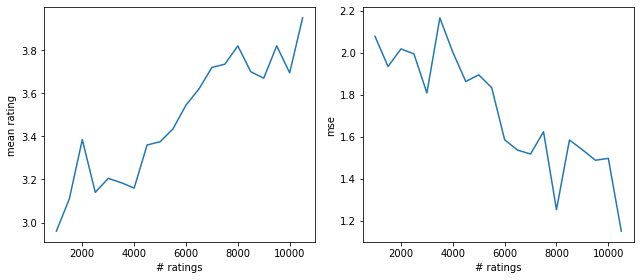

In [4]:
plot_ratings_mses(mean_ratings, mses)

## Partially Hidden User Behavior

Here, there is a portion of item utility that is unknown to a user until the item is consumed. From the paper "How Algorithmic Confounding in Recommendation Systems
Increases Homogeneity and Decreases Utility".

## User Interests Shift with Exposure

Here, the underlying user interest changes over time to match the body of items that have been recommended.

In [5]:
if topics:
    params = {'num_topics': 10, 'topic_change': 0.1}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8, 'affinity_change': 0.1}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'increasing_interest_'+env.name+'.npz'
mean_ratings, mses = run_experiment(env, params, datafilename)

Initializing environment and recommender
Making online recommendations
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 0 Mean: 3.5 MSE: [1.59337986]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 1 Mean: 3.45 MSE: [1.82988501]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 2 Mean: 3.25 MSE: [2.16662664]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 3 Mean: 3.6 MSE: [1.7694146]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 4 Mean: 3.6 MSE: [1.97971695]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 5 Mean: 3.0 MSE: [2.00483603]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 6 Mean: 3.9 MSE: [0.98428729]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 7 Mean

Writing libfm files
Running libfm
Reading in predicitions
Iter: 6 Mean: 2.95 MSE: [2.04206135]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 7 Mean: 3.3 MSE: [3.08244583]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 8 Mean: 4.05 MSE: [1.57662695]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 9 Mean: 3.8 MSE: [1.62808579]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 10 Mean: 3.9 MSE: [2.03298158]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 11 Mean: 3.75 MSE: [2.21669831]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 12 Mean: 3.7 MSE: [1.77000016]
Constructing test_inputs
Writing libfm files
Running libfm
Reading in predicitions
Iter: 13 Mean: 3.6 MSE: [2.16914923]
Constructing test_inputs
Writing libfm files
Running libfm
Reading

KeyboardInterrupt: 

In [ ]:
plot_ratings_mses(mean_ratings, mses)

## User Gets Bored

Here, user interest decreases for items too similar to those that they have recently been exposed to, with some decay in the effect.

In [ ]:
if topics:
    params = {'num_topics': 10, 'memory_length': 5, 'boredom_threshold': 2, 
              'boredom_penalty': 1.0}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8, 'memory_length': 5, 'boredom_threshold': 0.5, 
              'boredom_penalty': 1.0}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'boredom_'+env.name+'.npz'
mean_ratings, mses = run_experiment(env, params, datafilename)

In [ ]:
plot_ratings_mses(mean_ratings, mses)

## User Interests Shift, also Gets Bored

This is a combination of the previous two cases, where users gradually become more interested in topics that they are exposed to, but also exhibit boredom when they see many similar items in a row.

In [ ]:
if topics:
    params = {'num_topics': 10, 'topic_change': 0.1, 'memory_length': 5, 
              'boredom_threshold': 2, 'boredom_penalty': 1.0}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8, 'affinity_change': 0.1, 'memory_length': 5, 
              'boredom_threshold': 0.5, 'boredom_penalty': 1.0}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'boredom_and_interest_'+env.name+'.npz'
mean_ratings, mses = run_experiment(env, params, datafilename)

In [ ]:
plot_ratings_mses(mean_ratings, mses)